In [ ]:
# %cd /content/drive/MyDrive/IRProject

/content/drive/MyDrive/IRProject


In [ ]:
# %cp /content/drive/MyDrive/IRProject/kaggle.json /root/.kaggle/kaggle.json

In [ ]:
# Obtaining dataset
# !pip3 install kaggle
# !kaggle competitions download shopee-product-matching


0006c8e5462ae52167402bac1c2e916e.jpg: Skipping, found more recently modified local copy (use --force to force download)
0008377d3662e83ef44e1881af38b879.jpg: Skipping, found more recently modified local copy (use --force to force download)
0007585c4d0f932859339129f709bfdc.jpg: Skipping, found more recently modified local copy (use --force to force download)
0013e7355ffc5ff8fb1ccad3e42d92fe.jpg: Skipping, found more recently modified local copy (use --force to force download)
00303ad1c062fdeaf5f41b9ffb71a5fb.jpg: Skipping, found more recently modified local copy (use --force to force download)
001f4c8331d0554d133b10d85b7fafb2.jpg: Skipping, found more recently modified local copy (use --force to force download)
001be52b2beec40ddc1d2d7fc7a68f08.jpg: Skipping, found more recently modified local copy (use --force to force download)
002039aaf8618627a0442d5e89e5dda6.jpg: Skipping, found more recently modified local copy (use --force to force download)
00117e4fc239b1b641ff08340b429633.jpg: Sk

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import torch
import tensorflow as tf
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu
import numpy as np
from itertools import combinations
from tensorflow.keras.utils import plot_model, Progbar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
%cd '50045 Information Retrieval'

/content/drive/.shortcut-targets-by-id/1SZ9NcIihE82E7HPudYgIxdz_Gj_HXCf1/50045 Information Retrieval


In [ ]:
train = pd.read_csv('train.csv')
# test = pd.read_csv('/content/drive/MyDrive/IRProject/test.csv') #modify path accordingly
test = pd.read_csv('test.csv')

In [ ]:
print(train.shape)
print(test.shape)

(34250, 5)
(3, 4)


In [ ]:
tfidf = TfidfVectorizer()
cleaned_train = [title.strip() for title in train.title.values]
embedded_train = tfidf.fit_transform(cleaned_train).toarray()
print(embedded_train.shape)

(34250, 25069)


In [ ]:
embedded_train=torch.from_numpy(embedded_train)
embedded_train=embedded_train.cuda()


In [ ]:
matches = []
chunksize = 512
chunks = len(train)//chunksize if len(train)%chunksize==0 else (len(train)//chunksize)+1
for chunk in tqdm(range(chunks)): # Split into chunks for computation
    start = chunk*chunksize
    end = min(len(train),start+chunksize)
    cossim = torch.matmul(embedded_train,embedded_train[start:end].T).T # Calculate cosine similarity
    cossim = cossim.data.cpu().numpy() # Bring back to cpu and convert to numpy array
    for per_posting in cossim:
        indices = np.where(per_posting>=0.55)[0] # Only accept postings with >= 0.55 cosine similarity 
        match = train.iloc[indices].posting_id.values # Extract values 
        if len(match.tolist())>50:
            ind = np.where(per_posting>=sorted(per_posting)[-50])[0]
            match = train.iloc[ind].posting_id.values
        matches.append(' '.join(match.tolist()))

100%|██████████| 67/67 [04:22<00:00,  3.91s/it]


In [ ]:
train['matches'] = matches
train.head()

,posting_id,image,image_phash,title,label_group,matches
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,train_129225211 train_2278313361
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,train_3386243561 train_860027362 train_7788161...
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,train_2288590299 train_3803689425
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,train_2406599165 train_3576714541 train_150810...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,train_3369186413


In [ ]:
result = train[['posting_id','matches']]
result.head()

,posting_id,matches
0,train_129225211,train_129225211 train_2278313361
1,train_3386243561,train_3386243561 train_860027362 train_7788161...
2,train_2288590299,train_2288590299 train_3803689425
3,train_2406599165,train_2406599165 train_3576714541 train_150810...
4,train_3369186413,train_3369186413


In [ ]:
# %cd /content/drive/MyDrive/IRProject/

/content/drive/MyDrive/IRProject


In [ ]:
result.to_csv('result.csv',index=False)

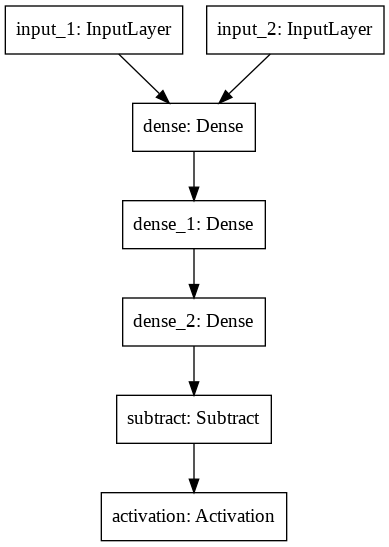

In [ ]:
# RankNet model architecture
class RankNet(Model):
    def __init__(self):
        super().__init__()
        self.dense = [layers.Dense(16, activation=leaky_relu), layers.Dense(8, activation=leaky_relu)]
        self.o = layers.Dense(1, activation='linear')
        self.oi_minus_oj = layers.Subtract()
    
    def call(self, inputs):
        xi, xj = inputs
        densei = self.dense[0](xi)
        densej = self.dense[0](xj)
        for dense in self.dense[1:]:
            densei = dense(densei)
            densej = dense(densej)
        oi = self.o(densei)
        oj= self.o(densej)
        oij = self.oi_minus_oj([oi, oj])
        output = layers.Activation('sigmoid')(oij)
        return output
    
    def build_graph(self):
        x = [Input(shape=(10)), Input(shape=(10))]
        return Model(inputs=x, outputs=self.call(x))

# visualize model architecture
plot_model(RankNet().build_graph(), show_shapes=False)

In [5]:
# TODO Slap in data here TODO
# generate data
nb_query = 20
query = np.array([i+1 for i in range(nb_query) for x in range(int(np.ceil(np.abs(np.random.normal(0,scale=15))+2)))])
doc_features = np.random.random((len(query), 10))
doc_scores = np.random.randint(5, size=len(query)).astype(np.float32)

# put data into pairs
xi = []
xj = []
pij = []
pair_id = []
pair_query_id = []
for q in np.unique(query):
    query_idx = np.where(query == q)[0]
    for pair_idx in combinations(query_idx, 2):
        pair_query_id.append(q)
        
        pair_id.append(pair_idx)
        i = pair_idx[0]
        j = pair_idx[1]
        xi.append(doc_features[i])
        xj.append(doc_features[j])
        
        if doc_scores[i] == doc_scores[j]:
            _pij = 0.5
        elif doc_scores[i] > doc_scores[j]:
            _pij = 1
        else: 
            _pij = 0
        pij.append(_pij)
        
xi = np.array(xi)
xj = np.array(xj)
pij = np.array(pij)
pair_query_id = np.array(pair_query_id)

xi_train, xi_test, xj_train, xj_test, pij_train, pij_test, pair_id_train, pair_id_test = train_test_split(
    xi, xj, pij, pair_id, test_size=0.2, stratify=pair_query_id)

print(xi_train)
print(xi_test)
print(pair_id_train)

[[0.59534971 0.94546503 0.39887216 ... 0.01145359 0.98031099 0.57786301]
 [0.58508937 0.22662181 0.29913925 ... 0.25727718 0.96556288 0.78452773]
 [0.59165719 0.43699422 0.90547281 ... 0.49701809 0.28158356 0.68666089]
 ...
 [0.95658053 0.58289643 0.43042902 ... 0.02506097 0.86760854 0.61471879]
 [0.07275114 0.65421985 0.38722382 ... 0.18609715 0.02386884 0.74170883]
 [0.4290912  0.21962814 0.91914864 ... 0.63696469 0.61189456 0.40441034]]
[[0.67161186 0.811563   0.52893553 ... 0.20401124 0.79782488 0.55735233]
 [0.56682586 0.81503049 0.66799587 ... 0.63638797 0.70224898 0.75670787]
 [0.4109273  0.91420317 0.6303878  ... 0.59360633 0.2669115  0.76345335]
 ...
 [0.16456559 0.28716419 0.70864353 ... 0.05680752 0.62292082 0.1183616 ]
 [0.23136279 0.85426216 0.97472415 ... 0.931668   0.72420755 0.20275772]
 [0.33245476 0.14498964 0.7932228  ... 0.78437299 0.66600693 0.0970065 ]]
[(226, 231), (79, 83), (156, 161), (217, 239), (174, 175), (201, 205), (179, 188), (154, 159), (136, 138), (47, 

In [ ]:
# Train model using compile and fit
ranknet = RankNet()
ranknet.compile(optimizer='adam', loss='binary_crossentropy')
history = ranknet.fit([xi_train, xj_train], pij_train, epochs=50, batch_size=1, validation_data=([xi_test, xj_test], pij_test))


Epoch 1/50
2018/2018 [==============================] - 8s 2ms/step - loss: 0.6838 - val_loss: 0.6654
Epoch 2/50
2018/2018 [==============================] - 5s 2ms/step - loss: 0.6647 - val_loss: 0.6452
Epoch 3/50
2018/2018 [==============================] - 5s 2ms/step - loss: 0.6373 - val_loss: 0.6186
Epoch 4/50
2018/2018 [==============================] - 5s 2ms/step - loss: 0.6061 - val_loss: 0.5862
Epoch 5/50
2018/2018 [==============================] - 5s 2ms/step - loss: 0.5766 - val_loss: 0.5896
Epoch 6/50
2018/2018 [==============================] - 5s 2ms/step - loss: 0.5550 - val_loss: 0.5646
Epoch 7/50
2018/2018 [==============================] - 5s 2ms/step - loss: 0.5347 - val_loss: 0.5492
Epoch 8/50
2018/2018 [==============================] - 5s 2ms/step - loss: 0.5161 - val_loss: 0.5360
Epoch 9/50
2018/2018 [==============================] - 5s 2ms/step - loss: 0.5046 - val_loss: 0.5224
Epoch 10/50
2018/2018 [==============================] - 5s 2ms/step - loss: 0.486

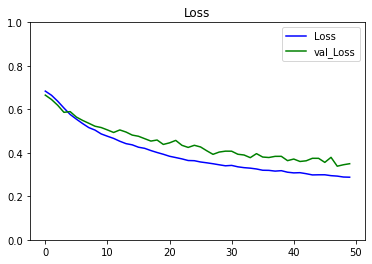

In [ ]:
# Plotting loss for visualisation
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=1.0)